In [1]:
# clear logs from previous runs so that tensorboard only shows current run
!rm -rf ./runs/

In [2]:
# view GPU information
!nvidia-smi

Wed May 11 09:20:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   26C    P0    37W / 250W |  30829MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:C1:00.0 Off |                    0 |
| N/A   

In [3]:
import numpy as np

import os

from datetime import datetime

import torch

from torch import nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import scipy.io as sio

import matplotlib.pyplot as plt

import copy

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 30

In [4]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:2'

In [5]:
# Requires 'ECG2(withDA).mat' file to have been uploaded
src_dataset = sio.loadmat('ECG2(withDA).mat');

# Prepare train, validation and test dataloaders

In [6]:
testdata = src_dataset['ECG']
data = testdata['Data'][0][0]
raw_labels = testdata['label'][0][0]

labels = np.empty(len(raw_labels), dtype='U1')
for i in range(len(raw_labels)):
  labels[i] = raw_labels[i][0][0]

## Pie Graph to show Class Distribution

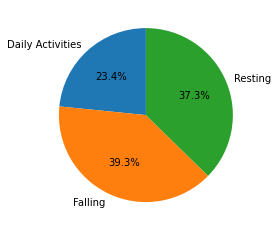

In [7]:
chart_labels = 'Daily Activities', 'Falling', 'Resting'
chart_values = [(labels == 'D').sum(), (labels == 'F').sum(), (labels == 'R').sum()]

fig1, ax1 = plt.subplots()
ax1.pie(chart_values, labels=chart_labels, autopct='%1.1f%%', startangle=90)

plt.savefig('distribution.png')
plt.show()


## Convert to dataloader

In [23]:
X = data
y = labels.reshape(-1, 1)
# labels as digit representation instead of letters
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
# 80/10/10 split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, train_size=0.5, random_state=RANDOM_SEED)
print((X_train.shape))
np.savetxt("X_train.csv", X_train, delimiter=",")
np.savetxt("X_val.csv", X_val, delimiter=",")
np.savetxt("X_test.csv", X_test, delimiter=",")
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("y_val.csv", y_val, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")

(1018, 4000)


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [31]:
def np_to_dataloader(X, y, device, batch_size):
  # X_tensor is 2d: num_samples, num_timestamps (4000) 
  X_tensor = torch.as_tensor(X.astype(np.float32), device=device)
  y_tensor = torch.as_tensor(y, device=device)
  # add feature dimension
  X_tensor = X_tensor.unsqueeze(dim=1)
  dataset = TensorDataset(X_tensor, y_tensor)
  # if generator parameter is not set, first run produces different results to subsequent runs!!
  return DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator())

dataloader_train = np_to_dataloader(X_train, y_train, device, BATCH_SIZE)
dataloader_val = np_to_dataloader(X_val, y_val, device, BATCH_SIZE)
dataloader_test = np_to_dataloader(X_test, y_test, device, BATCH_SIZE)

# Define models

In [49]:
EPOCHS = 100
class CNN(nn.Module):
    def __init__(self, hidden):
        super(CNN, self).__init__()

        self.hidden_last = hidden
        self.hidden1 = 64
        self.hidden2 = 128
        self.hidden3 = 256
        self.hidden4 = 512

        self.conv_kernel_size = 3
        
        self.activation = nn.ReLU()

        self.first = True

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.hidden1, kernel_size=self.conv_kernel_size),
            nn.BatchNorm1d(num_features=self.hidden1),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden1, out_channels=self.hidden2, kernel_size=self.conv_kernel_size),
            nn.BatchNorm1d(num_features=self.hidden2),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden2, out_channels=self.hidden3, kernel_size=self.conv_kernel_size),
            nn.BatchNorm1d(num_features=self.hidden3),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden3, out_channels=self.hidden4, kernel_size=self.conv_kernel_size),
            nn.BatchNorm1d(num_features=self.hidden4),
            self.activation,
            nn.MaxPool1d(kernel_size=2)
        )

        self.conv_last = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden4, out_channels=self.hidden_last, kernel_size=self.conv_kernel_size),
            nn.BatchNorm1d(num_features=self.hidden_last),
            self.activation,
            nn.Dropout(),
            nn.MaxPool1d(kernel_size=2)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv_last(x)
        if self.first:
          print('Size after CNN (batch size/features/seqence length): ', x.size())
          self.first = False
        return x

In [50]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.cnn_output = 1028
        self.seq_length_after_cnn = 123
        self.hidden_lstm = 64

        self.cnn = CNN(hidden=self.cnn_output)

        self.lstm = nn.LSTM(input_size=self.cnn_output, hidden_size=self.hidden_lstm, batch_first=True, num_layers=3)

        self.fc = nn.Linear(in_features=self.hidden_lstm*self.seq_length_after_cnn, out_features=3)


    def forward(self, x):
        # 3d: batch size, features (1), seq length (4000)
        x = self.cnn(x)
        # 3d: batch size, features (self.hidden_cnn), seq length after cnn
        x = x.permute(0, 2, 1)
        # 3d: batch size, seq length, features
        x, (h_n, c_n) = self.lstm(x)
        # 3d: batch size, seq length, features
        x = x.reshape(-1, self.hidden_lstm*self.seq_length_after_cnn)
        # 2d: batch size, (features*seq length)
        return self.fc(x)


In [51]:
model = CNN_LSTM().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Train and save best model

In [52]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    log_step = 10

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.float())
        loss = loss_fn(pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % log_step == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Train', train_loss, epoch)


def validation_loop(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    validation_loss /= num_batches
    correct /= size
    # For loss graph on tensorboard
    writer.add_scalar('Loss/Validation', validation_loss, epoch)
    print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {validation_loss:>8f}")
    return (correct, validation_loss)

In [54]:
epochs=100
%xmode Verbose

loss_of_best_accuracy = float('inf')
best_accuracy = 0
best_model = None

start_time = datetime.now()
for t in range(EPOCHS):
    print(f"\nEpoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer, t+1)
    accuracy, loss = validation_loop(dataloader_val, model, loss_fn, t+1)
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < loss_of_best_accuracy):
        best_accuracy = accuracy
        loss_of_best_accuracy = loss
        best_model = copy.deepcopy(model)
        print('Model saved')
end_time = datetime.now()
print(f"\nDone! Validation accuracy: {(100*best_accuracy):>0.2f}%")
print(f"Training took {(end_time-start_time).total_seconds():>0.2f} seconds")



Exception reporting mode: Verbose

Epoch 1
-------------------------------
loss: 0.138158  [    0/ 1018]
loss: 0.012732  [  320/ 1018]
loss: 0.070406  [  640/ 1018]
loss: 0.040480  [  960/ 1018]
Accuracy: 98.43%, Avg loss: 0.059678
Model saved

Epoch 2
-------------------------------
loss: 0.030964  [    0/ 1018]
loss: 0.168368  [  320/ 1018]
loss: 0.064871  [  640/ 1018]
loss: 0.066181  [  960/ 1018]
Accuracy: 96.85%, Avg loss: 0.097152

Epoch 3
-------------------------------
loss: 0.106403  [    0/ 1018]
loss: 0.049015  [  320/ 1018]
loss: 0.020661  [  640/ 1018]
loss: 0.023340  [  960/ 1018]
Accuracy: 97.64%, Avg loss: 0.039056

Epoch 4
-------------------------------
loss: 0.063263  [    0/ 1018]
loss: 0.023269  [  320/ 1018]
loss: 0.021171  [  640/ 1018]
loss: 0.036048  [  960/ 1018]
Accuracy: 96.85%, Avg loss: 0.096505

Epoch 5
-------------------------------
loss: 0.038292  [    0/ 1018]
loss: 0.011910  [  320/ 1018]
loss: 0.023782  [  640/ 1018]
loss: 0.008612  [  960/ 1018]
A

# Load model and test with new test data

In [46]:
@torch.no_grad()
def predict(model, loader):
    # initialise empty tensors for predictions and targets
    all_preds = torch.tensor([], device=device, dtype=int)
    all_targets = torch.tensor([], device=device, dtype=int)
    for batch in loader:
        data, labels = batch
        preds = model(data).argmax(1)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat((all_targets, labels.int()), dim=0)
    return all_preds, all_targets

with torch.no_grad():
  predictions, targets = predict(best_model, dataloader_test)

/home/test/conda/envs/torch-gpu/lib/python3.7/site-packages/torch/nn/modules/rnn.py:692: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


# Confusion Matrix

Test Accuracy: 99.22%


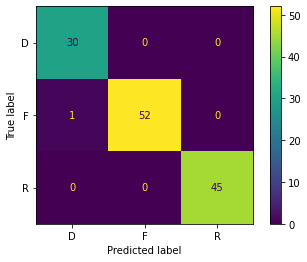

In [47]:
cm = confusion_matrix(targets.cpu(), predictions.cpu())
test_correct = 0
for i in range(3):
  test_correct += cm[i][i]
test_accuracy = test_correct/len(predictions)
print(f"Test Accuracy: {test_accuracy*100:>0.2f}%")
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
cmd.plot()


In [48]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from torchinfo import summary
print(summary(model))

Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─CNN: 1-1                               --
│    └─ReLU: 2-1                         --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  256
│    │    └─BatchNorm1d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─MaxPool1d: 3-4               --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-5                  24,704
│    │    └─BatchNorm1d: 3-6             256
│    │    └─ReLU: 3-7                    --
│    │    └─MaxPool1d: 3-8               --
│    └─Sequential: 2-4                   --
│    │    └─Conv1d: 3-9                  98,560
│    │    └─BatchNorm1d: 3-10            512
│    │    └─ReLU: 3-11                   --
│    │    └─MaxPool1d: 3-12              --
│    └─Sequential: 2-5                   --
│    │    └─Conv1d: 3-13                 393,728
│    │    └─BatchNorm1d: 3-14            1,024
│    │ 

# Tensorboard

In [ ]:
writer.flush()
writer.close()

%load_ext tensorboard
%tensorboard --logdir=runs